## Import packages

In [2]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
#import metpy as mtp
import math
from scipy import integrate
from scipy import interpolate
import pandas as pd
from random import randint

from matplotlib.pyplot import cm
from matplotlib.transforms import Bbox
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

import sys  
sys.path.insert(0, '../')
import ERA5_functions as era_fncts

%load_ext autoreload
%autoreload 2

### Constants

In [3]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [4]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

### Load instantaneous AHT calcs

In [5]:
aht_ds = xr.open_dataset('../aht_time_series/era5_aht_time_series.nc')

### Plot of a bunch of lats to show danger of lumping latitudes together

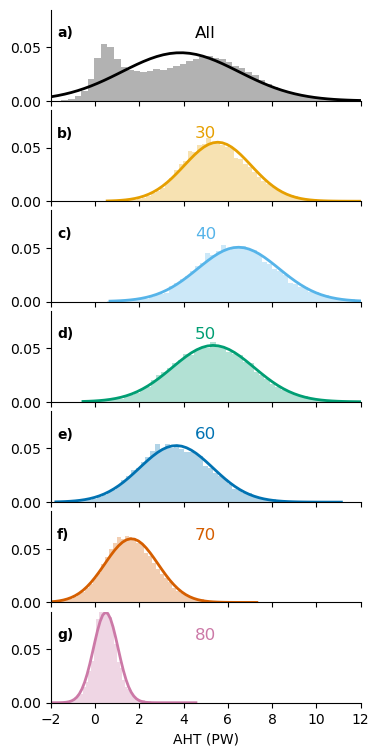

In [6]:
fig, axs = plt.subplots(7, 1, sharex=True, figsize=(4, 9))

all_data = []

eddy_aht_season = aht_ds.total_aht.groupby('time.season')['DJF']

lat_list = np.arange(30, 89, 10)
lat_list_str = lat_list.astype('str')

lat_colors = ['#E69F00', '#56B4E9', '#009E73', '#0072B2', '#D55E00', '#CC79A7']

lat_color_dict = dict(zip(lat_list, lat_colors))

ax_y_lim = [0, 0.085]
ax_x_lim = [-2, 12]

axs_for_plots = [axs[1], axs[2], axs[3], axs[4], axs[5], axs[6]]

for idx, ax in enumerate(axs_for_plots):
    eddy_aht = eddy_aht_season.sel(latitude=lat_list[idx]).values.flatten() / 1e15
    all_data.append(eddy_aht)
    era_fncts.plot_hist_and_gauss(ax, eddy_aht, lat_colors[idx], label=lat_list[idx])
    #ax.text(x=1.0e16, y=0.02, s='Skew: ' + str(round(sc.skew(eddy_aht), 2)))
    #ax.text(x=1.0e16, y=0.01, s='Kurtosis: ' + str(round(sc.kurtosis(eddy_aht), 2)))

era_fncts.plot_hist_and_gauss(axs[0], np.array(all_data).flatten(), 'k', label='All latitudes')    
#axs[6].text(x=1.0e16, y=0.02, s='Skew: ' + str(round(sc.skew(np.array(all_data).flatten()), 2)))
#axs[6].text(x=1.0e16, y=0.01, s='Kurtosis: ' + str(round(sc.kurtosis(np.array(all_data).flatten()), 2)))
    
#fig.legend(loc='upper right')

axs[6].set_xlabel('AHT (PW)')

plt.subplots_adjust(wspace=0.0, hspace=.1)

subplot_labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)']
for i, ax in enumerate((axs)):
    ax.patch.set_visible(False)
    ax.set_ylim(ax_y_lim)
    ax.set_xlim(ax_x_lim)
    ax.set_yticks([0, .05])
    for sp in ["top", "right"]:
        ax.spines[sp].set_visible(False)
    #ax.set_title(np.append(lat_list,'All')[i], x=0.5, y=.6, color=np.append(lat_colors, 'k')[i])
    ax.set_title(np.insert(lat_list_str, 0, 'All')[i], x=0.5, y=.6, color=np.insert(lat_colors, 0, 'k')[i])
    
    ax.text(x=0.02, y=0.7, s=subplot_labels[i], transform=ax.transAxes, fontweight='bold')

#fig.savefig('../figures/4_12_22_meeting/total_aht_pdfs_n_hem_djf_dif_lats_stacked_style_high_res', dpi=3000)
#fig.savefig('../figures/4_12_22_meeting/total_aht_pdfs_n_hem_djf_dif_lats_stacked_style.eps', format='eps')      
plt.show()

In [12]:
te_ds = xr.open_dataset('te_ds.nc')

te_ds

<xarray.Dataset>
Dimensions:   (time: 26280, latitude: 361)
Coordinates:
  * time      (time) datetime64[ns] 2001-01-01 ... 2018-12-31T18:00:00
  * latitude  (latitude) float64 90.0 89.5 89.0 88.5 ... -88.5 -89.0 -89.5 -90.0
Data variables:
    te_aht    (time, latitude) float64 ...

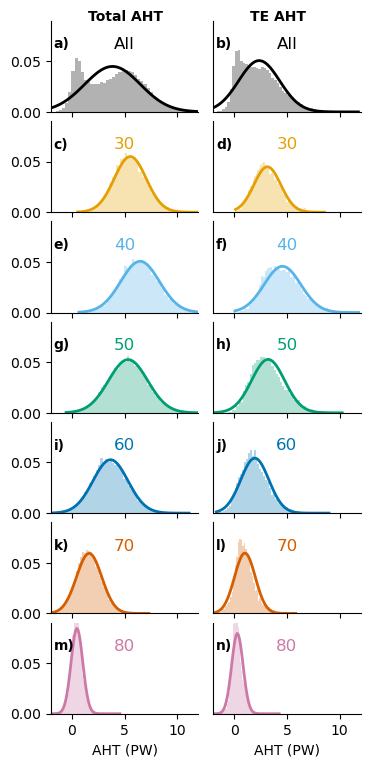

In [49]:
fig, axs = plt.subplots(7, 2, sharex=True, figsize=(4, 9))



aht_season = aht_ds.total_aht.groupby('time.season')['DJF']
te_season = te_ds.te_aht.groupby('time.season')['DJF']

lat_list = np.arange(30, 89, 10)
lat_list_str = lat_list.astype('str')

lat_colors = ['#E69F00', '#56B4E9', '#009E73', '#0072B2', '#D55E00', '#CC79A7']

lat_color_dict = dict(zip(lat_list, lat_colors))

ax_y_lim = [0, 0.09]
ax_x_lim = [-2, 12]

axs_for_plots = [axs[1, 0], axs[2, 0], axs[3,0], axs[4,0], axs[5,0], axs[6,0]]
all_data1 = []
for idx, ax in enumerate(axs_for_plots):
    one_aht = aht_season.sel(latitude=lat_list[idx]).values.flatten() / 1e15
    all_data1.append(one_aht)
    era_fncts.plot_hist_and_gauss(ax, one_aht, lat_colors[idx], label=lat_list[idx])
    
axs_for_plots = [axs[1, 1], axs[2, 1], axs[3,1], axs[4,1], axs[5,1], axs[6,1]]
all_data2 = []
for idx, ax in enumerate(axs_for_plots):
    te_aht = te_season.sel(latitude=lat_list[idx]).values.flatten() / 1e15
    all_data2.append(te_aht)
    era_fncts.plot_hist_and_gauss(ax, te_aht, lat_colors[idx], label=lat_list[idx])

era_fncts.plot_hist_and_gauss(axs[0, 0], np.array(all_data1).flatten(), 'k', label='All latitudes')  
era_fncts.plot_hist_and_gauss(axs[0, 1], np.array(all_data2).flatten(), 'k', label='All latitudes')  
#axs[6].text(x=1.0e16, y=0.02, s='Skew: ' + str(round(sc.skew(np.array(all_data).flatten()), 2)))
#axs[6].text(x=1.0e16, y=0.01, s='Kurtosis: ' + str(round(sc.kurtosis(np.array(all_data).flatten()), 2)))
    
#fig.legend(loc='upper right')

axs[6, 0].set_xlabel('AHT (PW)')
axs[6, 1].set_xlabel('AHT (PW)')

subplot_labels = [['a)', 'b)'], ['c)', 'd)'], ['e)', 'f)'],
                  ['g)', 'h)'], ['i)', 'j)'], ['k)', 'l)'], ['m)', 'n)']]
for i, ax_two in enumerate((axs)):
    ax_two[0].set_yticks([0, .05])
    ax_two[1].set_yticks([])
    for j, ax in enumerate(ax_two):
        #ax.patch.set_visible(False)
        ax.set_ylim(ax_y_lim)
        ax.set_xlim(ax_x_lim)
        for sp in ["top", "right"]:
            ax.spines[sp].set_visible(False)
        #ax.set_title(np.append(lat_list,'All')[i], x=0.5, y=.6, color=np.append(lat_colors, 'k')[i])
        ax.set_title(np.insert(lat_list_str, 0, 'All')[i], x=0.5, y=.6, color=np.insert(lat_colors, 0, 'k')[i])

        ax.text(x=0.02, y=0.7, s=subplot_labels[i][j], transform=ax.transAxes, fontweight='bold')

plt.subplots_adjust(wspace=0.1, hspace=.1)

axs[0,0].text(x=0.25, y=1, s='Total AHT', transform=axs[0,0].transAxes, fontweight='bold')
axs[0,1].text(x=0.25, y=1, s='TE AHT', transform=axs[0,1].transAxes, fontweight='bold')

    
#fig.savefig('figures/aht_distributions_by_lat')
plt.show()

### Quantitatively compare against a Gaussian

In [7]:
### Testing out some error quantification things
def standardize(array):
    array = array.flatten()
    return (array - np.mean(array)) / np.std(array)

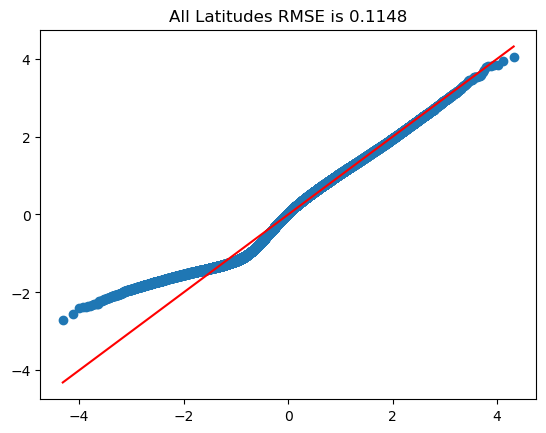

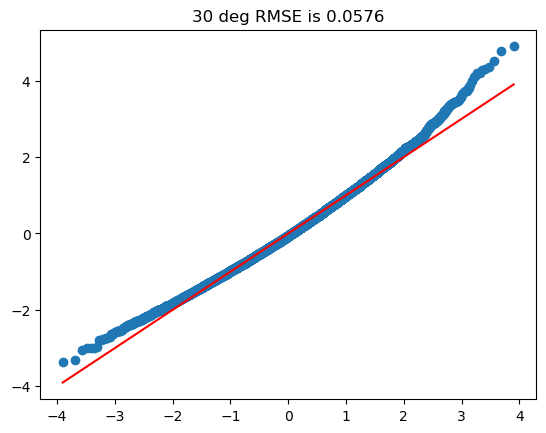

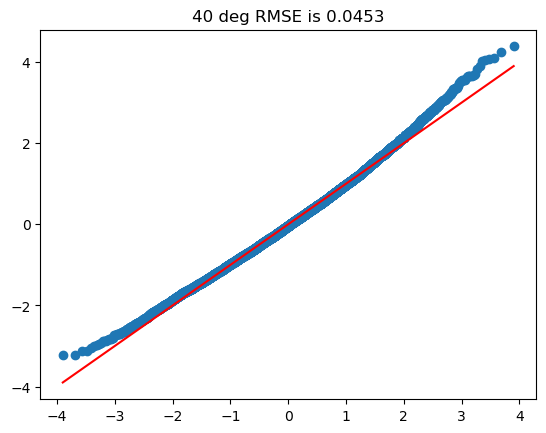

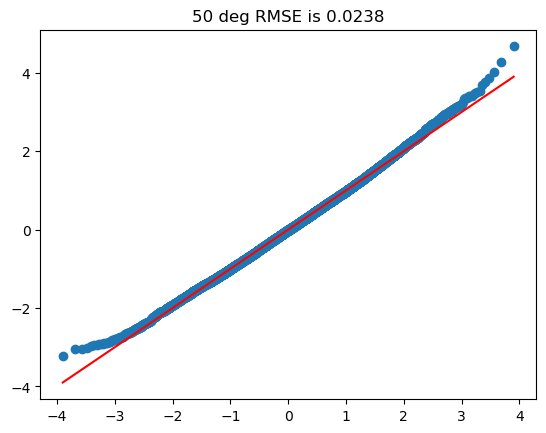

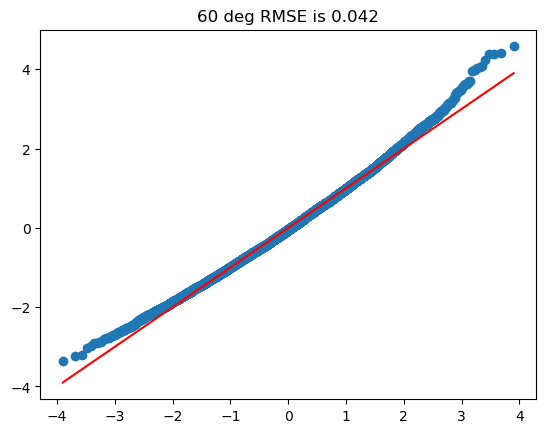

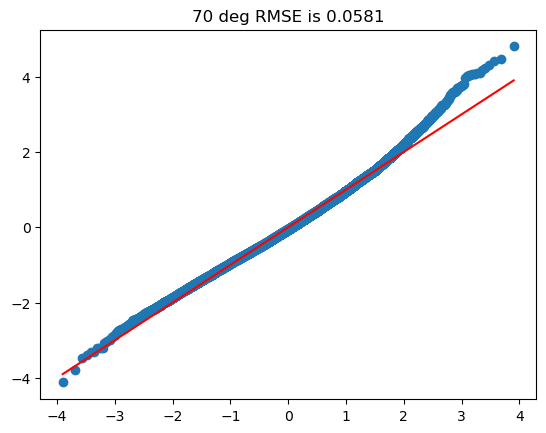

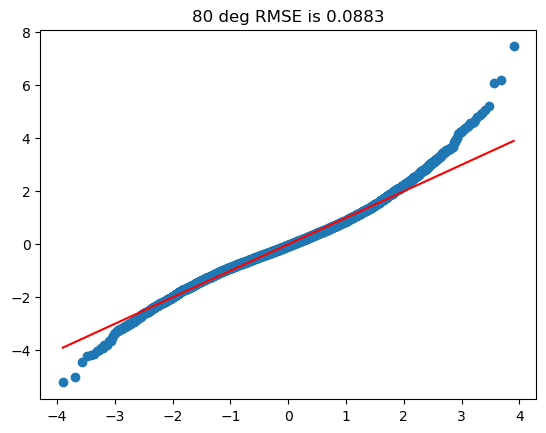

In [8]:
eddy_aht_season = aht_ds.total_aht.groupby('time.season')['DJF']


eddy_aht = eddy_aht_season.sel(latitude=lat_list).values.flatten() / 1e15

    
eddy_aht_std = standardize(eddy_aht)
    
quantiles = era_fncts.get_quantiles(eddy_aht_std)
    
plt.scatter(quantiles[0], quantiles[1])
plt.plot(quantiles[0], quantiles[0], color='r')
plt.title(f'All Latitudes RMSE is {round(quantiles[2], 4)}')
plt.show()

lat_list = np.arange(30, 89, 10)
lat_list_str = lat_list.astype('str')

rmses = []
for idx, ax in enumerate(lat_list):
    eddy_aht = eddy_aht_season.sel(latitude=lat_list[idx]).values.flatten() / 1e15
    
    eddy_aht_std = standardize(eddy_aht)
    
    quantiles = era_fncts.get_quantiles(eddy_aht_std)
    
    rmses.append(quantiles[2])
    plt.scatter(quantiles[0], quantiles[1])
    plt.plot(quantiles[0], quantiles[0], color='r')
    plt.title(f'{lat_list_str[idx]} deg RMSE is {round(quantiles[2], 4)}')
    plt.show()
    


In [9]:
np.mean(rmses)

0.05251144848697825